# Využití Large Language Models pro extrakci strukturovaných dat z volného textu klinické dokumentace pacientů s epilepsií

 Epilepsie je chronické neurologické onemocnění, které postihuje miliony lidí po celém světě. Správná diagnostika a efektivní léčebný plán jsou zásadní pro zlepšení kvality života pacientů trpících epilepsií. K dosažení tohoto cíle je nezbytné, aby lékaři měli přístup k přesným a dobře strukturovaným informacím o zdravotním stavu pacienta. V praxi však klinická dokumentace často obsahuje velké množství volného textu, který je pro lékaře a výzkumníky obtížně analyzovatelný. Přesná a rychlá interpretace těchto dat může významně přispět k lepšímu pochopení pacientových potřeb, zlepšení léčebných postupů a podpoře medicínského výzkumu.

- Install dependencies with `pip install -r requirements.txt`
- Start jupyter server with `jupyter notebook`

In [6]:
import ast
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ner_openai.consolidation import *
from ner_openai.openai_process import create_csv, openai_chat_completion_response

from dotenv import load_dotenv
import os

%load_ext autoreload
%autoreload 2

# promenne prostredi z .env
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
input_csv = 'tables_csv/BP_Kindlbar-Poskytnuta_veeg_data_18.csv'
output_csv = 'tables_csv/openai_csv/id_date_con.csv'

data_frame = pd.read_csv(input_csv)
id_column = 'Record ID'
eeg_summary_column = 'Závěr EEG'
date_column = 'Datum EEG'

# Create a new dataframe with necessary columns and drop rows with missing EEG summaries
filtered_df = data_frame[[id_column, date_column, eeg_summary_column]].copy()
filtered_df = filtered_df[filtered_df[eeg_summary_column].notna()]
filtered_df['ID and Date'] = filtered_df[id_column].astype(str) + ', ' + filtered_df[date_column].astype(str)
filtered_df = filtered_df[['ID and Date', eeg_summary_column]]
filtered_df.to_csv(output_csv, index=False)

# Aggregate EEG findings by patient ID into a list
grouped_data = data_frame.groupby(id_column)[eeg_summary_column].apply(list).to_dict()

# Identify patients with no EEG reports
no_reports_patients = tuple(
    patient_id for patient_id, eeg_reports in grouped_data.items() 
    if all(pd.isna(report) for report in eeg_reports)
)

print(f"Total number of patients: {len(grouped_data)}")
print(f"Number of patients without '{eeg_summary_column}' records: {len(no_reports_patients)}")
print(f"IDs of patients without records: {', '.join(map(str, no_reports_patients))}")


Total number of patients: 75
Number of patients without 'Závěr EEG' records: 28
IDs of patients without records: 151858, 152224, 179930, 205761, 315533, 366037, 379183, 482727, 587067, 611944, 622701, 756634, 858036, 940073, 959269, 1017118, 1159458, 1183509, 1321189, 1325997, 1367047, 1371957, 1386790, 1416851, 1447632, 1515986, 1570349, 2117795


In [19]:
from automatize_text_process.main import print_patient_dict

# Deleting patient records without EEG reports and cleaning record lists
aggregated_data = {record_id: [eeg_conclusion for eeg_conclusion in conclusions if not pd.isna(eeg_conclusion)]
                   for record_id, conclusions in grouped_data.items() if record_id not in no_reports_patients}

print_patient_dict(aggregated_data)


ID: 635785
 - video EEG ukazuje na možnou epileptogenní zónu ve frontálním laloku, spíše vlevo

ID: 824023
 - 2/13 Zachycen byl jeden krátký epileptický záchvat krátce po usnutí. Má chudou a obtížně klasifikovatelnou semiologii (probuzení, úzkost, pomrkávání, jemný třes, omezená reaktivita, bez dalších projevů). Iktální EEG vzorec sestává z rytmických strmých vln spíše nežli hrotů, lokalizovaný je opět nad širokou FCTP oblastí levé hemisféry, určité maximum pak je pod el. F7. Pozn. Semiologie záchvatů i EEG nález je v souladu s předchozími (tj. předoperačními) video/EEG záznamy; ukazuje na lokalizaci epileptogenní zóny v hlubších (v.s. operkulo-inzulárních) oblastech levé hemisféry.

ID: 997597
 - Zastiženy byly četné epileptické záchvaty s převahou ze spánku. Semiologicky mají prvky záchvatů tonických a hypermotorických (aura v podobě pocitu v ústech, poté vyděšený výraz, trismus, nekonstantně tonická křeč PHK, houpavé hypermotorické automatizmy, vokalizace, bez poruchy vědomí a zřete

In [20]:
from automatize_text_process.main import write_to_csv

write_to_csv(aggregated_data)


In [21]:
file_csv = 'tables_csv/aggregated_data.csv'

df = pd.read_csv(file_csv)

# Finding duplicated patient IDs
duplicates = df[id_column].value_counts()[df[id_column].value_counts() > 1]

# Output duplicated IDs and their counts
print("Pacienti s vícero zápisy v 'Závěr EG':")
print(duplicates)

Pacienti s vícero zápisy v 'Závěr EG':
Record ID
1845579    2
1878718    2
Name: count, dtype: int64


## <font color='green'>Práce s českým textem</font>



Chyba při zpracování záznamu 635785, 01.08.2019: malformed node or string on line 1: <ast.Name object at 0x152af6350>
{'Přítomnost epileptických záchvatů': ['epileptický záchvat'], 'Semiologie': ['probuzení', 'úzkost', 'pomrkávání', 'jemný třes', 'omezená reaktivita'], 'Iktální_EEG': ['rytmické strmé vlny', 'FCTP oblast levé hemisféry', 'el. F7']}
{'Délka_Monitorování': None, 'Přítomnost epileptických záchvatů': 'přítomnost epileptických záchvatů', 'Typy EEG aktivit': None, 'Lokalizace': 'levá hemisféra', 'Specifika': 'semiologické prvky záchvatů tonických a hypermotorických, aura v podobě pocitu v ústech, vyděšený výraz, trismus, nekonstantně tonická křeč PHK, houpavé hypermotorické automatizmy, vokalizace, bez poruchy vědomí a zřetelná postiktální afázie, operkulo-inzulární oblast', 'Aktivita během spánku vs. bdělosti': 'ze spánku', 'Lateralita': 'levá hemisféra', 'Typ_aktivity': None, 'Pacientova reakce': None, 'Terapie_Redukce': None, 'Okcipitální_Rytmus': None, 'Asymetrie_MU_Rytmu

/Users/barbora/PycharmProjects/Bachelor_thesis/venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/barbora/PycharmProjects/Bachelor_thesis/venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


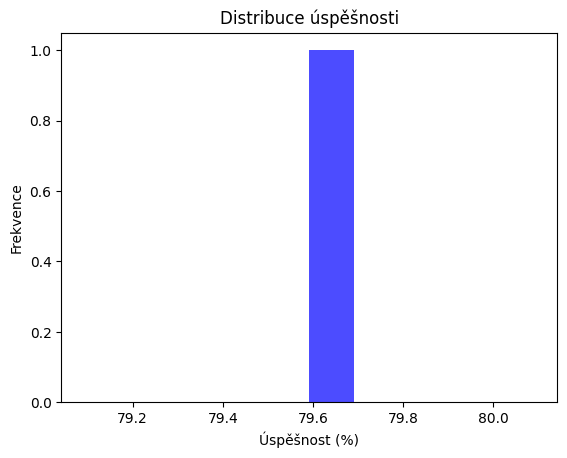

In [2]:
from automatize_text_process.columns import columns_csv
from scipy import stats

def process_records(df, output_file):
    total_records = 0
    successful_records = 0

    with open(output_file, mode='a', encoding='utf-8', newline='') as file:
        writer = csv.writer(file)

        
        for index, row in df.iterrows():
            record_id = row['ID a Datum']
            eeg_conclusion = row['Závěr EEG']
            total_records += 1

            try:
                response_str = openai_chat_completion_response(eeg_conclusion)
                response_dict = ast.literal_eval(
                response_str.strip().replace("  ", " ").replace("\n", ""))
                print(response_dict)

                data_row = [record_id]

                for col in columns_csv:
                    # Change from '' to None to maintain consistency with None values !
                    value = response_dict.get(col, None)
                    # Converting lists to readable strings
                    cleaned_value = ', '.join(value) if isinstance(value, list) else value
                    data_row.append(cleaned_value)

                writer.writerow(data_row)
                successful_records += 1
            except Exception as e:
                print(f"Chyba při zpracování záznamu {record_id}: {e}")

    return successful_records / total_records * 100

df = pd.read_csv('tables_csv/openai_csv/id_date_con.csv')
output_file = 'tables_csv/openai_csv/table_openai.csv'
create_csv(output_file)


# Run the script multiple times to gather data
results = [process_records(df, output_file) for _ in range(10)]

# Compute statistics
mean_success_rate = np.mean(results)
median_success_rate = np.median(results)
std_deviation = np.std(results)
confidence_interval = stats.norm.interval(0.95, loc=mean_success_rate, scale=std_deviation)

print(f"Průměrná úspěšnost: {mean_success_rate:.2f}%")
print(f"Střední úspěšnost: {median_success_rate:.2f}%")
print(f"Standardní odchylka: {std_deviation:.2f}%")
print(f"95% interval spolehlivosti: {confidence_interval}")

plt.hist(results, bins=10, color='blue', alpha=0.7)
plt.title('Distribuce úspěšnosti')
plt.xlabel('Úspěšnost (%)')
plt.ylabel('Frekvence')
plt.show()


### <font color='yellow'>Postprocesing</font>

In [5]:
# Save the first column to a new table and remove the first column from the original table
df = pd.read_csv('tables_csv/openai_csv/table_openai.csv')
first_column = df.iloc[:, 0]
first_column.to_csv('tables_csv/openai_csv/first_column.csv', index=False)
df.drop(df.columns[0], axis=1, inplace=True)

# Merge the first column with the modified original table
df_first_column = pd.read_csv('tables_csv/openai_csv/first_column.csv')
df_first_column[['ID', 'Date']] = df_first_column.iloc[:, 0].str.split(',', expand=True)
df_first_column.drop(columns=[df_first_column.columns[0]], inplace=True)
final_df = pd.concat([df_first_column, df], axis=1)
final_df.to_csv('tables_csv/openai_csv/combined_table.csv', index=False)


### <font color='yellow'>Příklad použití SQL </font>


In [14]:
import sqlite3

# Load CSV file into DataFrame
file_path = 'tables_csv/openai_csv/final_table.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

# Connect to SQLite database (create a new one if it doesn't exist)
conn = sqlite3.connect('ner_openai/eeg_data.db')

# Load data into SQL table
df.to_sql('eeg_monitoring', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

# Connect to SQLite database
conn = sqlite3.connect('ner_openai/eeg_data.db')

query1 = "SELECT COUNT(*) as Count FROM eeg_monitoring WHERE `Přítomnost epileptických záchvatů` = 'True';"
result1 = pd.read_sql_query(query1, conn)

# Display results for the count of records with epileptic seizures
print("Count of records with epileptic seizures:")
print(result1)

# Another example SQL query: Records with a specific type of EEG activity (spikes)
query2 = "SELECT * FROM eeg_monitoring WHERE `Typy EEG aktivit` LIKE '%hroty%';"
result2 = pd.read_sql_query(query2, conn)

# Display results for records with a specific type of EEG activity
print("Records with a specific type of EEG activity (spikes):")
print(result2)

# Close the connection
conn.close()


Count of records with epileptic seizures:
   Count
0     30
Records with a specific type of EEG activity (spikes):
         ID         Date  Délka_Monitorování (hod)  \
0   1087093   18.12.2018                      80.0   
1   1263134   23.04.2019                      80.0   
2   1467197   27.10.2017                       NaN   
3   1509746   25.11.2014                       NaN   
4   1527079   13.10.2014                      80.0   
5   1790439   05.11.2017                      80.0   
6   1822536   31.08.2018                      80.0   
7   1845579   17.06.2019                      56.0   
8   1859764   12.10.2018                       NaN   
9   1863465   17.06.2019                      72.0   
10  1868137   12.03.2019                      80.0   
11  1878718   08.12.2018                      80.0   
12  1878718   14.06.2021                      56.0   
13  1924892   18.12.2019                      96.0   
14  1961596   11.10.2019                      56.0   
15  1992049   01.10.2

## <font color='green'>Práce s anglickým textem</font>


In [5]:
cleaned_df = pd.read_csv('tables_csv/openai_csv/combined_table.csv')

# Remove curly braces and rename the column
cleaned_df.replace(to_replace=r'\{|\}', value='', regex=True, inplace=True)
cleaned_df.rename(columns={'Délka_Monitorování': 'Délka_Monitorování (hod)'}, inplace=True)


# Extracting numbers from column values and assigning null to values that do not contain numbers
cleaned_df['Délka_Monitorování (hod)'] = cleaned_df['Délka_Monitorování (hod)'].str.extract('(\d+)').astype(float)
cleaned_df['Přítomnost epileptických záchvatů'] = cleaned_df['Přítomnost epileptických záchvatů'].apply(detect_seizures)
cleaned_df['Typy EEG aktivit'] = cleaned_df['Typy EEG aktivit'].apply(clean_typy_eeg_aktivit)
cleaned_df['Lokalizace'] = cleaned_df['Lokalizace'].apply(clean_lokalizace)
cleaned_df['Specifika'] = cleaned_df['Specifika'].apply(clean_specifika)
cleaned_df['Aktivita během spánku vs. bdělosti'] = cleaned_df['Aktivita během spánku vs. bdělosti'].apply(clean_sleep_awake)
cleaned_df['Lateralita'] = cleaned_df['Lateralita'].apply(clean_lateralita)
cleaned_df['Typ_aktivity'] = cleaned_df['Typ_aktivity'].apply(clean_typ_aktivity)
cleaned_df['Pacientova reakce'] = cleaned_df['Pacientova reakce'].apply(clean_pacientova_reakce)
cleaned_df['Terapie_Redukce'] = cleaned_df['Terapie_Redukce'].apply(clean_terapie_redukce)
cleaned_df['Okcipitální_Rytmus'] = cleaned_df['Okcipitální_Rytmus'].apply(clean_okcipitalni_rytm)
cleaned_df['Asymetrie_MU_Rytmu'] = cleaned_df['Asymetrie_MU_Rytmu'].apply(clean_asymetrie_mu_rytmu)
cleaned_df['Areální_Diferenciace_Vlevo/Vpravo'] = cleaned_df['Areální_Diferenciace_Vlevo/Vpravo'].apply(clean_arealni_diferenciace)
cleaned_df['Epileptiformní_Aktivita'] = cleaned_df['Epileptiformní_Aktivita'].apply(clean_epileptiformni_aktivita)
cleaned_df['Maxima_Epileptiformní_Aktivity'] = cleaned_df['Maxima_Epileptiformní_Aktivity'].apply(clean_maxima_epileptiformni_aktivity)
cleaned_df['REM_Epileptiformní_Aktivita'] = cleaned_df['REM_Epileptiformní_Aktivita'].apply(clean_rem_epileptiformni_aktivita)


final_dir = 'tables_csv/openai_csv/final_table.csv'
cleaned_df.to_csv(final_dir, index=False)

final_df = pd.read_csv(final_dir)
final_df


,ID,Date,Délka_Monitorování (hod),Přítomnost epileptických záchvatů,Typy EEG aktivit,Lokalizace,Specifika,Aktivita během spánku vs. bdělosti,Lateralita,Typ_aktivity,...,Areální_Diferenciace_Vlevo/Vpravo,FCTP_Oblast_Zpomalení,Epileptiformní_Aktivita,Maxima_Epileptiformní_Aktivity,Stav_Spánku,NREM_Epileptiformní_Aktivita,REM_Epileptiformní_Aktivita,Charakter_Záchvatů,Semiologie,Iktální_EEG
0,824023,02.07.2013,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"probuzení, úzkost, pomrkávání, jemný třes, ome...","rytmické strmé vlny, FCTP oblast levé hemisfér..."
1,997597,01.02.2014,NaN,True,NaN,levá strana,ostatní: semiologické prvky záchvatů tonických...,spánek,"levá strana, hemisféra",NaN,...,ostatní: levá hemisféra,NaN,NaN,NaN,NaN,NaN,NaN,záchvaty tonické a hypermotorické,semiologické prvky záchvatů tonických a hyperm...,NaN
2,1087093,18.12.2018,80.0,True,"rytmická aktivita, hroty, intermitentní aktivita","frontální lalok, temporální lalok, levá strana",NaN,"spánek, REM spánek, NREM spánek",levá strana,ostatní: ze bdění i ze spánku,...,ostatní: levá hemisféra,nad širší fronto-temporální oblastí levé hemis...,"přítomna, spike/hroty",maxima vlevo,zachovaná spánková organizace,charakteristika v NREM spánku,NaN,"stereotypní, hypermotorické","změna výrazu tváře, hlasitá vokalizace, hyperv...",pomalá rytmická aktivita nad širší fronto-temp...
3,1263134,23.04.2019,80.0,True,hroty,"frontální lalok, levá strana, elektrody: F3",NaN,"bdění, REM spánek, NREM spánek",levá strana,"ostatní: normální, zpomalení, epileptiformní",...,diferenciace vlevo,regionálně frontálně vlevo,spike/hroty,elektrody: F3,organizace stadií zachována,polyspike,NaN,uniformní fokální záchvaty,"bipedální a ""houpavé"" automatizmy, bez vokaliz...","preiktální vzorec, oploštění a náborový rytmic..."
4,1263748,24.06.2018,80.0,True,"rytmická aktivita, epileptiformní aktivity","frontální lalok, pravá strana","ostatní: epileptiformní aktivity, periodický c...",bdění,ostatní: pravé hemisféry,"spike/hroty, ostré vlny, komplexní aktivita",...,ostatní: ano,Ano,NaN,ostatní: frontobazálně,Charakteristika epileptiformní aktivity,Ano,ostatní: ano,Fokální,Uniformní,Rychlá rytmická aktivita
5,1467197,27.10.2017,NaN,True,"rytmická aktivita, hroty","frontální lalok, temporální lalok, pravá strana","ostatní: simplexní parciální záchvaty, automat...","bdění, REM spánek, NREM spánek",ostatní: pravé hemisféře,spike/hroty,...,NaN,NaN,přítomna,"elektrody: F8, F7",organizovanou,NaN,NaN,velmi četné epileptické záchvaty s převahou ze...,"orbitofrontální lokalizaci epileptogenní zóny,...","nelateralizované, bilaterální rytmickou iktáln..."
6,1478716,14.01.2015,NaN,True,NaN,"levá strana, pravá strana","ostatní: bilaterální tonické záchvaty, symetri...","spánek, bdění",levá strana,NaN,...,ostatní: doleva,NaN,epileptiformní aktivita,NaN,"NREM spánku, REM spánku",NREM spánku,ostatní: rem spánku,NaN,"motorickými fenomény, bilaterální tonické zách...",vlevo frontocentrálně parasagitálně
7,1494726,29.10.2017,56.0,NaN,rytmická aktivita,"frontální lalok, pravá strana",NaN,bdění,"levá strana, pravá strana",NaN,...,NaN,NaN,epileptiformní aktivita,ostatní: frontálně vpravo,NaN,NaN,NaN,"fokální záchvaty, suspenzorická aura, třes, ve...",NaN,iktální EEG
8,1509746,25.11.2014,NaN,NaN,"ostré vlny, hroty, sw komplexy",NaN,NaN,"bdění, REM spánek, NREM spánek",levá strana,NaN,...,NaN,NaN,NaN,NaN,NaN,"ostré vlny, hroty, šířením do dalších regionů",NaN,NaN,"simplexní parciální záchvaty tonické, asymetri...","nelateralizované, lokalizovanou CP vlevo, levo..."
9,1527079,13.10.2014,80.0,True,"hroty, epileptiformní aktivity, intermitentní ...","temporální lalok, levá strana","ostatní: komplexní parciální záchvat, automoto...","bdění, REM spánek, NREM spánek",levá strana,pomalé vlny,...,NaN,přítomnost intermitentního zpomalení nad oblas...,"přítomna, epileptiformní aktivita",ostatní: lokalizace maximální epileptiformní a...,spánková organizace nenarušena,epileptiformní aktivita téměř kontinuální,NaN,"p

In [ ]:
import deepl


auth_key = os.getenv('DEEPL_API_KEY')
translator = deepl.Translator(auth_key)

glossary_languages = translator.get_glossary_languages()
for language_pair in glossary_languages:
    print(f"{language_pair.source_lang} to {language_pair.target_lang}")


de to en
de to es
de to fr
de to ja
de to it
de to pl
de to nl
de to zh
de to ru
de to pt
de to ko
de to da
de to sv
de to nb
en to de
en to es
en to fr
en to ja
en to it
en to pl
en to nl
en to zh
en to ru
en to pt
en to ko
en to da
en to sv
en to nb
es to de
es to en
es to fr
es to ja
es to it
es to pl
es to nl
es to zh
es to ru
es to pt
es to ko
es to da
es to sv
es to nb
fr to de
fr to en
fr to es
fr to ja
fr to it
fr to pl
fr to nl
fr to zh
fr to ru
fr to pt
fr to ko
fr to da
fr to sv
fr to nb
ja to de
ja to en
ja to es
ja to fr
ja to it
ja to pl
ja to nl
ja to zh
ja to ru
ja to pt
ja to ko
ja to da
ja to sv
ja to nb
it to de
it to en
it to es
it to fr
it to ja
it to pl
it to nl
it to zh
it to ru
it to pt
it to ko
it to da
it to sv
it to nb
pl to de
pl to en
pl to es
pl to fr
pl to ja
pl to it
pl to nl
pl to zh
pl to ru
pl to pt
pl to ko
pl to da
pl to sv
pl to nb
nl to de
nl to en
nl to es
nl to fr
nl to ja
nl to it
nl to pl
nl to zh
nl to ru
nl to pt
nl to ko
nl to da
nl to sv
n

In [20]:
import openai
from scipy.spatial.distance import cosine


def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.Embedding.create(input=[text], model=model)
    return response['data'][0]['embedding']

def calculate_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)

def process_data(path):
    openai.api_key = os.getenv('OPENAI_API_KEY')
    data = pd.read_csv(path)
    results = []

    # Processing each row in the data file
    for index, row in data.iterrows():
        # Obtaining embeddings for Czech and English sentences
        embedding_cz = get_embedding(row['Závěr EEG'])
        embedding_en = get_embedding(row['Conclusion EEG'])

        # Calculating similarity
        similarity = calculate_similarity(embedding_cz, embedding_en)

        # Storing results
        results.append({
            'Record ID': row['Record ID'],
            'Similarity': similarity
        })

    # Printing statistics
    similarities = [result['Similarity'] for result in results]
    print("Average Similarity:", np.mean(similarities))
    print("Median Similarity:", np.median(similarities))
    print("Maximum Similarity:", max(similarities))
    print("Minimum Similarity:", min(similarities))

    return results


data_path = 'tables_csv/aggregated_data2.csv'
process_data(data_path)


In [ ]:
def remove_extra_spaces_and_update(path_csv, column_index):
    # Load data from a CSV file
    with open(path_csv, 'r', newline='') as file:
        reader = csv.reader(file)
        data = list(reader)

    modifications = 0
    # Modify a specific column in each row
    for row in data:
        # Check if the column index is valid
        if len(row) > column_index:
            original_value = row[column_index]
            # Remove extra spaces and the text "Summary:" and "Conclusion:"
            modified_value = original_value.replace('  ', ' ').replace('Summary:', '').replace('Conclusion:', '')
            # Check if the value has changed
            if modified_value != original_value:
                row[column_index] = modified_value
                modifications += 1

    # Write the modified data back to the same CSV file
    with open(path_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

    print(f"Number of modified rows: {modifications}")

file_csv = 'tables_csv/aggregated_data2.csv'
remove_extra_spaces_and_update(file_csv, 2)

df_eng = pd.read_csv(file_csv)
df_eng


Number of rows changed: 0


,Record ID,Závěr EEG,Conclusion EEG
0,635785,video EEG ukazuje na možnou epileptogenní zónu...,EEG video shows a possible epileptogenic zone ...
1,824023,2/13 Zachycen byl jeden krátký epileptický zác...,2/13 One brief epileptic seizure was recorded ...
2,997597,Zastiženy byly četné epileptické záchvaty s př...,Numerous epileptic seizures were observed with...
3,1087093,80-hodinové video/EEG monitorování s částečnou...,80-hour video/EEG monitoring with partial redu...
4,1243060,Výhradně ze spánku byly zachyceny krátké semio...,Short semiologically uniform epileptic seizure...
5,1263134,80-hodinové video/EEG monitorování bdění a spá...,80-hour video/EEG monitoring of wakefulness an...
6,1263748,80-hodinové video/EEG monitorování bdění a spá...,80-hour video/EEG monitoring of wakefulness an...
7,1467197,Video/EEG monitorování bdění a spánku při naku...,Video/EEG monitoring of wakefulness and sleep ...
8,1478716,Zachyceny byly četné epileptické záchvaty ze b...,Numerous epileptic seizures from wakefulness a...
9,1494726,56-hodinová video/EEG monitorace bdění a spánk...,56-hour video/EEG monitoring of wakefulness an...


In [12]:
# Loading data from CSV files
id_date_df = pd.read_csv('tables_csv/BP_Kindlbar-Poskytnuta_veeg_data_18.csv', usecols=['Record ID', 'Datum EEG'])
conclusion_df = pd.read_csv('tables_csv/aggregated_data2.csv', usecols=['Record ID', 'Conclusion EEG'])

# Filtering only rows with 'Conclusion EEG' filled
id_date_df = id_date_df[id_date_df['Závěr EEG'].notna()]

# Merging tables based on 'Record ID'
merged_df = pd.merge(id_date_df, conclusion_df, on='Record ID')

# Saving the resulting table to a new CSV file
merged_df.to_csv('tables_csv/azure_csv/merged_id_date_conclusion.csv', index=False)


### Using Microsoft Azure


In [16]:
from ner_azure.azure_process import analyze_health_data
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential


key = os.getenv('AZURE_KEY')
endpoint = os.getenv('AZURE_ENDPOINT')

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
        endpoint=endpoint,
        credential=ta_credential)
    return text_analytics_client

client = authenticate_client()
# Setup Azure Text Analytics Client
credential = AzureKeyCredential(key)
client = TextAnalyticsClient(endpoint=endpoint, credential=credential)

# Load the CSV file to check its structure and first few rows
file_path = 'tables_csv/azure_csv/merged_id_date_conclusion.csv'
data = pd.read_csv(file_path)
patient_ids = data['Record ID'].tolist()
conclusion_eegs = data['Conclusion EEG'].tolist()

# Opening CSV file
with open(file_path, mode='r', encoding='utf-8') as file_csv:
    csv_reader = csv.reader(file_csv)
    next(csv_reader)

    for row in csv_reader:
        patient_id = [row[0]]
        eeg_date = [row[1]]
        conclusion_eeg = [row[2]]
        analyze_health_data(client, conclusion_eeg, patient_id, eeg_date)

print('All done.')


Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 635785
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 824023
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 997597
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1087093
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1243060
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1263134
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1263748
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1467197
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1478716
Data has been appended to tables_csv/azure_csv/combined_health_data.csvfrom patient with id 1494726
Dat

### <font color='yellow'>Postprocesing</font>

In [2]:
# Load the file combined_health_data.csv
combined_health_data_path = 'tables_csv/azure_csv/combined_health_data.csv'
combined_health_data = pd.read_csv(combined_health_data_path)
# Remove rows where the 'Entity' column contains the value 'el'
combined_health_data = combined_health_data[combined_health_data['Entity'] != 'el']
combined_health_data['Entity'] = combined_health_data['Entity'].str.replace(r'^el\. ', '', regex=True)

# List of electrode abbreviations
electrode_abbreviations = ['Fz','F9', 'F8', 'F7', 'F4', 'F3', 'Fp2', 'Fp1', 'T3', 'T4', 'T5', 'T6', 'P3', 'P4', 'P10', 'O1', 'O2', 'C4', 'C3', 'Pz', 'Cz']
for abbreviation in electrode_abbreviations:
    combined_health_data.loc[combined_health_data['Entity'] == abbreviation, 'Category'] = 'Electrode'
    combined_health_data.loc[combined_health_data['Entity'] == abbreviation, 'Normalized Text'] = None

# Replace 'c.' with 'central' in the 'Entity' column
combined_health_data['Entity'] = combined_health_data['Entity'].replace('c.', 'central')

# If 'REM' or 'NREM' is in the 'Entity' column, set 'Normalized Text' to None and 'Category' to 'Sleep'
combined_health_data.loc[combined_health_data['Entity'].isin(['REM', 'NREM']), 'Normalized Text'] = None
combined_health_data.loc[combined_health_data['Entity'].isin(['REM', 'NREM']), 'Category'] = 'Sleep'

# If 'L' is in the 'Entity' column, set 'Category' to 'Direction'
combined_health_data.loc[combined_health_data['Entity'] == 'L', 'Category'] = 'Direction'

# If 'R' is in the 'Entity' column, set 'Category' to 'Direction'
combined_health_data.loc[combined_health_data['Entity'] == 'R', 'Category'] = 'Direction'

# If 'hour' is contained in the 'Entity' column, set 'Category' to 'Duration'
combined_health_data.loc[combined_health_data['Entity'].str.contains('hour'), 'Category'] = 'Duration'

combined_health_data.to_csv('tables_csv/azure_csv/final_table2.csv', index=False)


### <font color='yellow'> Soubory, které se nahrají do AZURE Language Studia </font>

In [ ]:
import os

def save_column_to_files(csv_path, column_name, output_folder):
    # Create the folder if it does not exist
    os.makedirs(output_folder, exist_ok=True)

    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Get data from the specified column
    column_data = df[column_name]

    # Save each row into a separate file in the specified folder
    for index, value in enumerate(column_data):
        # Format the filename with leading zeros (e.g., text01.txt, text02.txt)
        filename = f'text{index + 1:02d}.txt'
        # Build the full file path
        full_path = os.path.join(output_folder, filename)
        # Write the value to the file
        with open(full_path, 'w', encoding='utf-8') as file:
            file.write(str(value))

# Use the function
save_column_to_files('tables_csv/veeg_data.csv', 'Conclusion EEG', 'texts')
